# Import Library

In [204]:
import numpy as np
import pandas as pd
import json
from utils.utils import *

import xgboost as xgb
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import category_encoders as ce

In [205]:
data = pd.read_csv('data/train/train.csv')
df_train = data.drop('CO2_working_capacity [mL/g]', axis=1)
df_train = df_train.loc[df_train['surface_area [m^2/g]'] > 0, :]
df_train = df_train.reset_index(drop=True)

df_test = data.drop('CO2_working_capacity [mL/g]', axis=1)
df_test = df_test.loc[df_test['surface_area [m^2/g]'] <= 0, :]
df_test = df_test.reset_index(drop=True)
print(df_train.isnull().sum())

MOFname                                            0
volume [A^3]                                       0
weight [u]                                         0
surface_area [m^2/g]                               0
void_fraction                                      0
void_volume [cm^3/g]                               0
functional_groups                                296
metal_linker                                       0
organic_linker1                                    0
organic_linker2                                    0
topology                                           0
CO2/N2_selectivity                                 0
heat_adsorption_CO2_P0.15bar_T298K [kcal/mol]      0
dtype: int64


# Density

In [206]:
df_train.insert(loc=3, column="density [g/cm^3]", value=(df_train["weight [u]"] / df_train["volume [A^3]"]) * 1.66054)
df_test.insert(loc=3, column="density [g/cm^3]", value=(df_test["weight [u]"] / df_test["volume [A^3]"]) * 1.66054)

## Catalog Heat Absorp

In [207]:
generate_selectivity_catalog(df_train)

,MOFname,volume [A^3],weight [u],density [g/cm^3],surface_area [m^2/g],void_fraction,void_volume [cm^3/g],functional_groups,metal_linker,organic_linker1,organic_linker2,catalog CO2/N2,topology,CO2/N2_selectivity,heat_adsorption_CO2_P0.15bar_T298K [kcal/mol]
0,mof_unit_2,2769.503842,2211.697211,1.326090,603.61,0.13794,0.1040,F-OMe,10,44,57,1.0,etb,33.616780,7.147286
1,mof_unit_3,1089.818728,773.687960,1.178856,788.50,0.14874,0.1262,OMe-COOH,2,22,24,1.0,pcu,19.263726,6.347967
2,mof_unit_4,2205.198301,1304.638720,0.982408,1441.53,0.21814,0.2220,H-SO3H,9,17,24,1.0,sra,25.701377,6.190085
3,mof_unit_6,3954.659761,1543.027680,0.647909,2430.55,0.37094,0.5725,Pr-NO2,9,7,23,1.0,sra,17.146541,5.398304
4,mof_unit_7,3565.914939,1954.749656,0.910268,1530.02,0.33337,0.3662,NH2,10,53,55,1.0,etb,18.363791,6.303857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54069,mof_unit_66520,1426.479810,1272.451540,1.481238,1343.62,0.30190,0.2038,Me-I,3,12,21,0.0,pcu,5.867674,4.485481
54070,mof_unit_66521,23943.701366,5497.752320,0.381279,4182.24,0.66340,1.7399,HCO-Me,1,9,27,0.0,pcu,4.060772,3.605688
54071,mof_unit_66522,14389.971556,4396.164320,0.507298,4149.64,0.57051,1.1246,OPr-Cl,1,9,20,0.0,pcu,4.313411,3.361233
54072,mof_unit_66523,16997.806645,3932.703680,0.384191,4326.62,0.66963,1.7430,CN,2,2,5,0.0,nbo,3.447440,2.781566


In [208]:
generate_selectivity_catalog(df_test)

,MOFname,volume [A^3],weight [u],density [g/cm^3],surface_area [m^2/g],void_fraction,void_volume [cm^3/g],functional_groups,metal_linker,organic_linker1,organic_linker2,catalog CO2/N2,topology,CO2/N2_selectivity,heat_adsorption_CO2_P0.15bar_T298K [kcal/mol]
0,mof_unit_1,1116.667429,875.240600,1.301526,0.0,0.07899,0.0607,COOH-OEt,3,4,11,1.0,pcu,22.864166,6.786041
1,mof_unit_5,1137.800963,901.736120,1.316020,0.0,0.07778,0.0591,NHMe-OH,2,1,22,1.0,pcu,30.001838,6.478063
2,mof_unit_12,1175.475860,1397.051280,1.973549,0.0,0.05704,0.0289,Me-Br,2,22,24,1.0,pcu,58.106974,7.407898
3,mof_unit_14,1071.619874,701.628600,1.087216,0.0,0.10455,0.0962,OEt-CN,2,12,22,1.0,pcu,31.664456,7.427183
4,mof_unit_20,919.305781,689.174400,1.244854,0.0,0.07816,0.0628,CN,3,10,18,1.0,pcu,47.332721,7.957782
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14534,mof_unit_68609,1188.302573,1001.700216,1.399781,0.0,0.00000,0.0000,Pr-F,3,4,24,1.0,pcu,24.131770,NaN
14535,mof_unit_68610,1506.660363,1493.296496,1.645811,0.0,0.01108,0.0000,SO3H,10,42,46,0.0,etb,6.071818,NaN
14536,mof_unit_68611,2035.532738,1959.518320,1.598529,0.0,0.00000,0.0000,OPr,4,14,22,1.0,acs,9.876134,NaN
14537,mof_unit_68612,3985.426053,3638.677280,1.516066,0.0,0.00000,0.0000,OPr-Me,4,4,15,0.0,acs,5.285051,inf


# Encode

In [209]:
function_groups_encoder = {}

for i, ele in enumerate(df_train['functional_groups'].unique()):
    function_groups_encoder[ele] = i
    
topo_encoder = {}

for i, ele in enumerate(df_train['topology'].unique()):
    topo_encoder[ele] = i


encoder = {'functional_groups': function_groups_encoder, 'topology': topo_encoder}
df_train = df_train.replace(encoder)
df_test = df_test.replace(encoder)

# Preprocessing Data

### Extract Features and Target and train_test_split

In [210]:
all_features = list(df_train.columns)
all_features.remove('MOFname')
all_features.remove('functional_groups')
all_features.remove('topology')
all_features.remove('surface_area [m^2/g]')

features_idx = {}
for idx, feat in enumerate(all_features):
    features_idx[feat] = idx

print(features_idx)

{'volume [A^3]': 0, 'weight [u]': 1, 'density [g/cm^3]': 2, 'void_fraction': 3, 'void_volume [cm^3/g]': 4, 'metal_linker': 5, 'organic_linker1': 6, 'organic_linker2': 7, 'catalog CO2/N2': 8, 'CO2/N2_selectivity': 9, 'heat_adsorption_CO2_P0.15bar_T298K [kcal/mol]': 10}


In [211]:
target = ['surface_area [m^2/g]']

X, y = df_train[all_features].values, df_train[target].values
y_max = y.max()
y /= y_max

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
print(check_nan_inf(X_train), check_nan_inf(X_test))

0 0


### Target Encode Topology

In [212]:
# target_encoder_train_test(df_train, X_train, X_test, y_train, y_test, features_idx, 'topology')

# X_train = X_train.astype(float)
# X_test = X_test.astype(float)
# print(X_train.shape, X_test.shape)

### Fill nan and inf (Heat adsorption)

In [213]:
clean_heat_adsorption_train_test(X_train, X_test, features_idx, num_catalog)

print(check_nan_inf(X_train), check_nan_inf(X_test))

0 0


In [214]:
# X_train = np.delete(X_train, features_idx['catalog CO2/N2'], 1)
# X_test = np.delete(X_test, features_idx['catalog CO2/N2'], 1)
# all_features.remove('catalog CO2/N2')

### Convert CO2/N2 selectivity by square root selectivity and multiply by heat adsorption

In [215]:
# X_train[:, features_idx['CO2/N2_selectivity']] = np.sqrt(X_train[:, features_idx['CO2/N2_selectivity']]) * X_train[:, features_idx['heat_adsorption_CO2_P0.15bar_T298K [kcal/mol]']]
# X_test[:, features_idx['CO2/N2_selectivity']] = np.sqrt(X_test[:, features_idx['CO2/N2_selectivity']]) * X_test[:, features_idx['heat_adsorption_CO2_P0.15bar_T298K [kcal/mol]']]

### Scale Data

In [216]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Model

In [217]:
n_estimators = 100
xg_reg = xgb.XGBRegressor(objective ='reg:logistic', n_estimators=n_estimators)
xg_reg.fit(X_train,y_train)

preds = xg_reg.predict(X_train)
mae = mean_absolute_error(y_train, preds)
print("train MAE: {}".format(mae))

preds = xg_reg.predict(X_test)
mae = mean_absolute_error(y_test, preds)
print("val MAE: {}".format(mae))

train MAE: 0.01375748318461639
val MAE: 0.01573312334903479


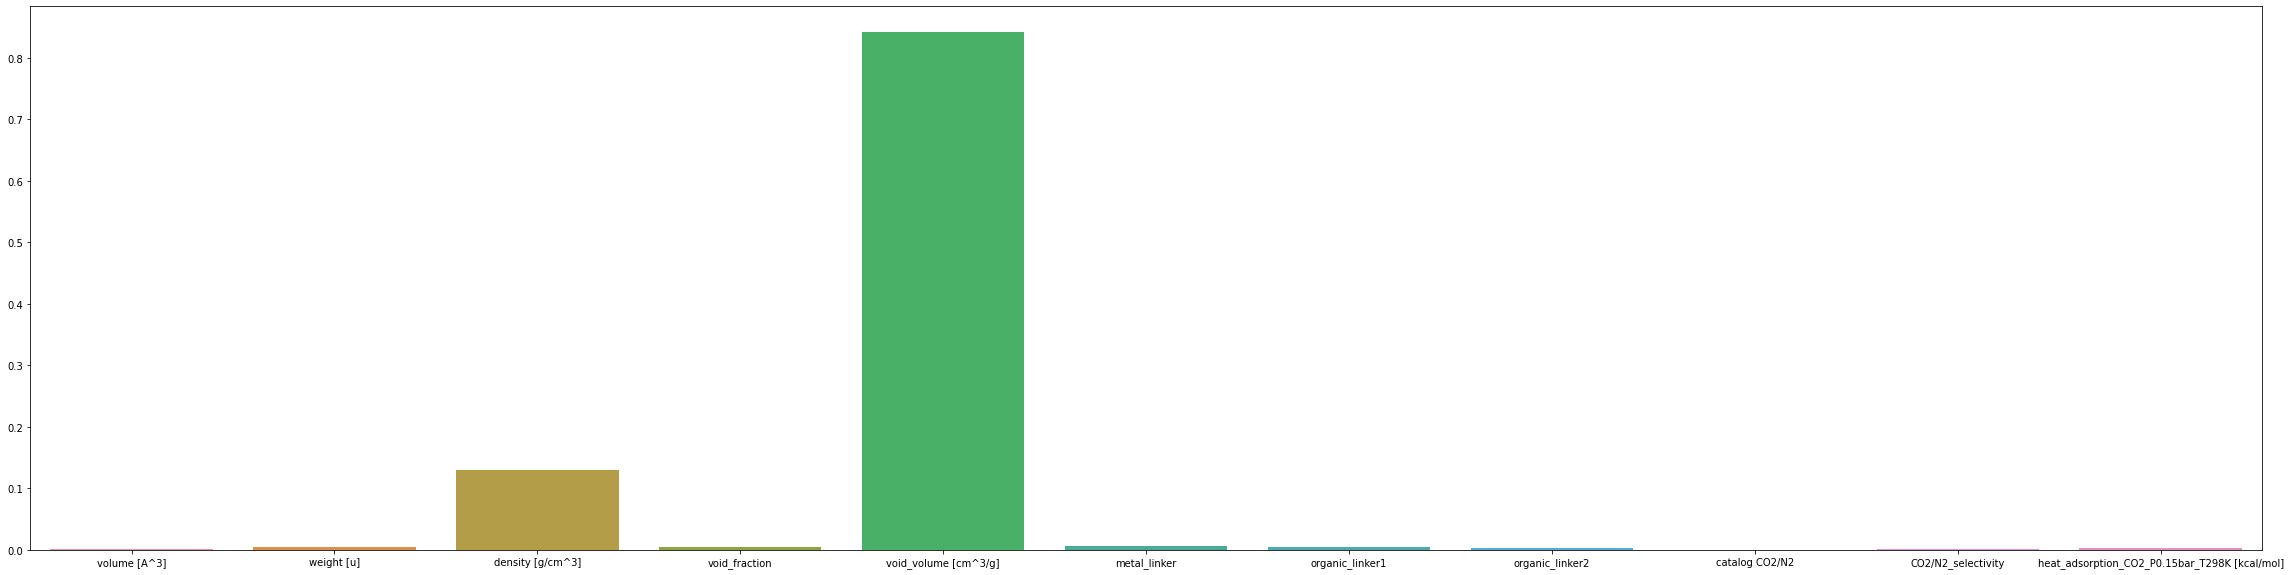

In [218]:
plt.figure(figsize=(40, 10))
sns.barplot(x=all_features, y=xg_reg.feature_importances_)
plt.show()

In [219]:
clean_heat_adsorption(X, features_idx, 2)

sc = StandardScaler()
X = sc.fit_transform(X)

xg_reg = xgb.XGBRegressor(objective ='reg:logistic', n_estimators=n_estimators)
xg_reg.fit(X, y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=16, num_parallel_tree=1,
             objective='reg:logistic', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

# Predict

In [220]:
X = df_test[all_features].values

clean_heat_adsorption(X, features_idx, 2)

X = sc.transform(X)
pred = xg_reg.predict(X)

In [221]:
data.loc[data['surface_area [m^2/g]'] <= 0, 'surface_area [m^2/g]'] = pred*y_max

In [222]:
data['surface_area [m^2/g]']

0         343.224426
1         603.610000
2         788.500000
3        1441.530000
4         329.140778
            ...     
68608     174.727066
68609     132.329071
68610     134.595947
68611     127.778877
68612     142.590698
Name: surface_area [m^2/g], Length: 68613, dtype: float64

In [223]:
data.to_csv('data/train/clean_train.csv', index=False)

In [224]:
xg_reg.save_model('model/model_surface_area.json')